### Still in progress!

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data_ml = pd.read_csv('data_ml.csv')

# 1 Data Inspection

In [4]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7030 entries, 0 to 7029
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7030 non-null   int64  
 1   gender            7030 non-null   object 
 2   SeniorCitizen     7030 non-null   object 
 3   Partner           7030 non-null   object 
 4   Dependents        7030 non-null   object 
 5   tenure            7030 non-null   int64  
 6   PhoneService      7030 non-null   object 
 7   MultipleLines     7030 non-null   object 
 8   InternetService   7030 non-null   object 
 9   OnlineSecurity    7030 non-null   object 
 10  OnlineBackup      7030 non-null   object 
 11  DeviceProtection  7030 non-null   object 
 12  TechSupport       7030 non-null   object 
 13  StreamingTV       7030 non-null   object 
 14  StreamingMovies   7030 non-null   object 
 15  Contract          7030 non-null   object 
 16  PaperlessBilling  7030 non-null   object 


In [5]:
#Checking levels of categorical features
for i in data_ml.columns:
    if data_ml[i].dtype == 'object':
        print(f'{i} {data_ml[i].unique()}')

gender ['Female' 'Male']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


# 2 Feature Engineering

The dataset was partially processed during the exploratory data analysis (Part 1): Datatypes were changed. Redundant variables were deletet, outliers were and missing values were transformed (-> see Part 1: Exploratory Data Analysis)

## 2.1 Delete redundant variable

In [6]:
#Delete first column
data_ml = data_ml.iloc[:,1:]

## 2.2 One Hot Encoding

In [7]:
from sklearn.preprocessing import OneHotEncoder

#Seperate data into categorical features and numerical features 
data_cat = data_ml.select_dtypes(include=['object','category']).copy()
data_num = data_ml.select_dtypes(include=['float64','int64']).copy()

ohe = OneHotEncoder()

#instantiate and fit One Hot Encoder with categorical features
ohe = OneHotEncoder(drop='first', sparse_output=False)
data_cat_encoded = ohe.fit_transform(data_cat)

#Generate Dataframe with encoded categorical features
feature_names = ohe.get_feature_names_out(input_features=data_cat.columns)
data_cat_df = pd.DataFrame(data_cat_encoded, columns=feature_names, index=data_cat.index)

#Concat encoded categorical features with numerical features
data_trans = pd.concat([data_cat_df, data_num], axis=1)

## 2.3 Train Test Split

In [8]:
from sklearn.model_selection import train_test_split

#Train/Test Split
X = data_trans.drop(columns='Churn_Yes')
y = data_trans['Churn_Yes']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=123)

In [9]:
# Check Stratify
print('y_train',y_train.value_counts(normalize=True))
print('')
print('y_test',y_test.value_counts(normalize=True))

y_train Churn_Yes
0.0    0.735953
1.0    0.264047
Name: proportion, dtype: float64

y_test Churn_Yes
0.0    0.736131
1.0    0.263869
Name: proportion, dtype: float64


## 2.4 Quantile Transforming

Quantile transformation of the features 'MonthlyCharges' and 'Total Charges' and 'tenure
.fit_transform of X_train and .transform of X_test to avoid data leakage

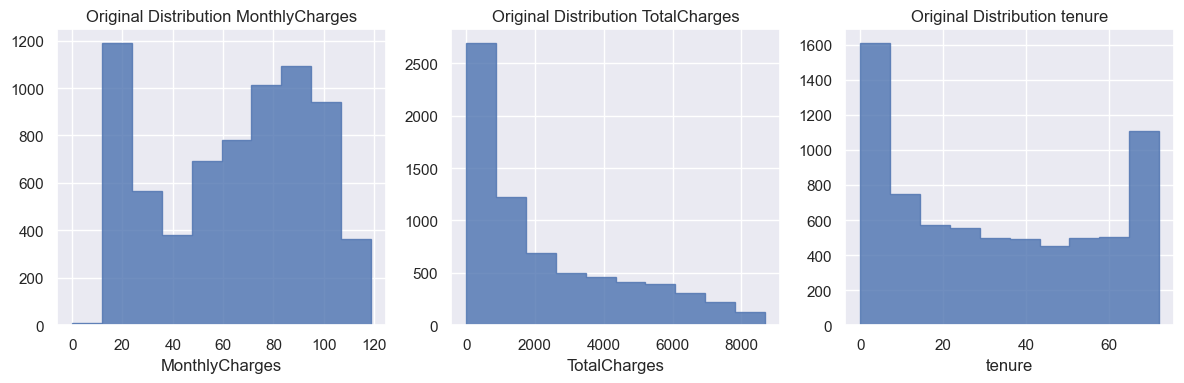

In [10]:
#Plot original distribution of Monthly and Total Charges

def dist_before_quantile():

    fig, ax = plt.subplots(1,3,figsize=(12,4))

    #Subplot 1: Monthlycharges
    data_ml.MonthlyCharges.hist(ax=ax[0],histtype='step',fill=True,alpha=0.8)
    ax[0].set_title('Original Distribution MonthlyCharges')
    ax[0].set_xlabel('MonthlyCharges')
    ax[0].set_ylabel=('Count')

    #Subplot 2: Totalcharges
    data_ml.TotalCharges.hist(ax=ax[1],histtype='step',fill=True,alpha=0.8)
    ax[1].set_title('Original Distribution TotalCharges')
    ax[1].set_xlabel('TotalCharges')
    ax[1].set_ylabel=('Count')

    #Subplot 3: tenure
    data_ml.tenure.hist(ax=ax[2],histtype='step',fill=True,alpha=0.8)
    ax[2].set_title('Original Distribution tenure')
    ax[2].set_xlabel('tenure')
    ax[2].set_ylabel=('Count')

    plt.tight_layout()

dist_before_quantile()

In [11]:
#Quantile Transforming

from sklearn.preprocessing import QuantileTransformer

#Instantiate Quantile Transformer
quantile_normal = QuantileTransformer(output_distribution='normal')

# Fit Transform X_train
X_train[['MonthlyCharges','TotalCharges','tenure']] = quantile_normal.fit_transform(X_train[['MonthlyCharges','TotalCharges','tenure']])

#Transform X_test
X_test[['MonthlyCharges','TotalCharges','tenure']] = quantile_normal.transform(X_test[['MonthlyCharges','TotalCharges','tenure']])

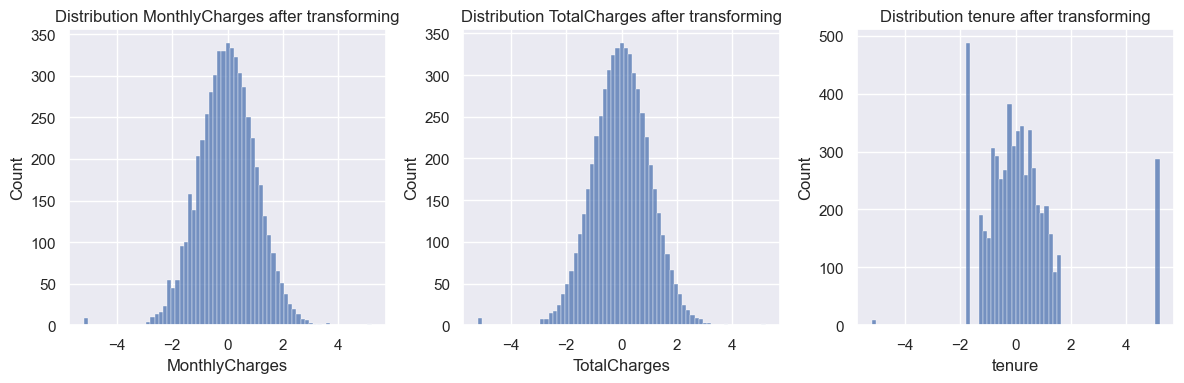

In [12]:
#Plot distribution after transforming

def dist_after_quantile():
    fig, ax = plt.subplots(1,3,figsize=(12,4))

    #Subplot 1: transformed MonthlyCharges
    sns.histplot(X_train.MonthlyCharges,ax=ax[0])
    ax[0].set_title('Distribution MonthlyCharges after transforming')
    ax[0].set_xlabel('MonthlyCharges')
    ax[0].set_ylabel=('Count')

    #Subplot 2: transformed TotalCharges
    sns.histplot(X_train.TotalCharges,ax=ax[1])
    ax[1].set_title('Distribution TotalCharges after transforming')
    ax[1].set_xlabel('TotalCharges')
    ax[1].set_ylabel=('Count')

    #Subplot 3: transformed tenure
    sns.histplot(X_train.tenure,ax=ax[2])
    ax[2].set_title('Distribution tenure after transforming')
    ax[2].set_xlabel('tenure')
    ax[2].set_ylabel=('Count')

    plt.tight_layout()

dist_after_quantile()

## 2.5 Class Balancing

In [13]:
#Original Distribution target 'Churn'
data_ml.Churn.value_counts(normalize=True)

Churn
No     0.735989
Yes    0.264011
Name: proportion, dtype: float64

In [14]:
#Oversampling/Undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE()
under = RandomUnderSampler()
steps = [('o',over),('u',under)]
pipeline = Pipeline(steps=steps)
X_train_bal, y_train_bal = pipeline.fit_resample(X_train,y_train)


#https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [15]:
y_train_bal.value_counts()

Churn_Yes
0.0    4139
1.0    4139
Name: count, dtype: int64

# 3 Training

In [28]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.model_selection import ValidationCurveDisplay

import mlflow
from mlflow.models.signature import infer_signature
mlflow.set_tracking_uri(uri='http://127.0.0.1:8080')

## 3.1 Metric

Goal is to keep as much as customers as possible. Therefore, recall is the best metric for this. It answers the question, how good the model is in predicting customers which are truly churned.

Recall (True Positive Rate) = True Positives / True Positives + False Negative

## 3.2 Model 1: Logistic Regression

In [29]:
#Instantiate LogisticRegression
lr = LogisticRegression(max_iter=1000)

#Dictionary for hyperparameter tuning
lr_param_dict = {'penalty':['l1','l2'],
                 'solver':['saga'],
                 'C':[0.001, 0.01, 0.1]
                 }

#Instantiate GridsearchCV
gridcv_lr = GridSearchCV(estimator=lr,cv=5,param_grid=lr_param_dict,scoring='recall')

#Fit Gridsearch with balanced Classes
model_lr = gridcv_lr.fit(X_train_bal,y_train_bal)

#Best params
best_params_lr = model_lr.best_params_

#Best score
best_score_lr = model_lr.best_score_

#Mean test score
mean_test_score_lr = model_lr.cv_results_['mean_test_score']


print(f'best params: {best_params_lr}')
print(f'best recall: {best_score_lr} \n')
print(f'mean_test_score: {mean_test_score_lr} \n')


####################################################################################

#Set new experiment

mlflow.set_experiment('Churn Prediction Telco Data')

#start MlFlow run
with mlflow.start_run():
    mlflow.log_param("best_params", best_params_lr)
    mlflow.log_param("param_dict", lr_param_dict)
    mlflow.log_metric('recall', best_score_lr)  
    mlflow.set_tag("Training Info", "GridSearchCV Log Regression")

    best_model_lr = model_lr.best_estimator_

    # Infer signature
    signature = infer_signature(X_train_bal, best_model_lr.predict(X_train_bal))

    # Log Model
    model_info_lr = mlflow.sklearn.log_model(
        sk_model=best_model_lr,
        artifact_path="Log Regression",
        signature=signature,
        input_example=X_train_bal,
        registered_model_name="Log Regression",
    )

best params: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
best recall: 0.8113070933295947 

mean_test_score: [0.7175645  0.81082225 0.80574745 0.80502486 0.81130709 0.80768361] 



Registered model 'Log Regression' already exists. Creating a new version of this model...
2025/04/01 18:36:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Log Regression, version 16


🏃 View run glamorous-boar-233 at: http://127.0.0.1:8080/#/experiments/213517147752326983/runs/4530fe508eb548c9b4fb0ec441f388b9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/213517147752326983


Created version '16' of model 'Log Regression'.


## 3.3 Model 2: K Nearest Neighbors

In [30]:
'''
ValidationCurveDisplay.from_estimator(
   KNeighborsClassifier(), X_train_bal, y_train_bal,
       param_name="n_neighbors", param_range=[20,30,40,50,60,70,80,90,100],scoring='recall')'
'''

'\nValidationCurveDisplay.from_estimator(\n   KNeighborsClassifier(), X_train_bal, y_train_bal,\n       param_name="n_neighbors", param_range=[20,30,40,50,60,70,80,90,100],scoring=\'recall\')\'\n'

In [31]:
#Instantiate KNN
knn = KNeighborsClassifier()

#Dictionary for hyperparameter tuning
#neighbors_range = range(60,100)
#knn_param_dict = {'n_neighbors':neighbors_range}

knn_param_dict = {
    'n_neighbors': [10,20,30,40],
    'weights': ['uniform'], 
    'metric': ['euclidean', 'manhattan','hamming'],  
    'leaf_size': [10]
}

#Instantiate GridsearchCV
gridcv_knn = GridSearchCV(estimator=knn,cv=5,param_grid=knn_param_dict,scoring='recall',return_train_score=True)

#Fit Gridsearch with training data
model_knn = gridcv_knn.fit(X_train_bal,y_train_bal)

#Best params
best_params_knn = model_knn.best_params_

#Best score
best_score_knn = model_knn.best_score_

#Mean test score
mean_test_score_knn = model_knn.cv_results_['mean_test_score']


print(f'best params: {best_params_knn}')
print(f'best recall: {best_score_knn} \n')
print(f'mean_test_score: {mean_test_score_knn} \n')


####################################################################################


#start MlFlow run
with mlflow.start_run():
    mlflow.log_param("best_params", best_params_knn)
    mlflow.log_param("param_dict", knn_param_dict)
    mlflow.log_metric('recall', best_score_knn)
    mlflow.set_tag("Training Info", "GridSearchCV KNN")

    best_model_knn = model_knn.best_estimator_

    # Infer signature
    signature = infer_signature(X_train_bal, best_model_knn.predict(X_train_bal))

    # Log Model
    model_info_knn = mlflow.sklearn.log_model(
        sk_model=best_model_knn,
        artifact_path="KNN",
        signature=signature,
        input_example=X_train_bal,
        registered_model_name="KNN",
    )

best params: {'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 40, 'weights': 'uniform'}
best recall: 0.8915204832086175 

mean_test_score: [0.88089217 0.88065092 0.88306667 0.89152048 0.8439263  0.84706698
 0.85141627 0.85866265 0.72892446 0.75670604 0.7644396  0.77410318] 



Registered model 'KNN' already exists. Creating a new version of this model...
2025/04/01 18:40:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: KNN, version 21


🏃 View run righteous-sponge-996 at: http://127.0.0.1:8080/#/experiments/213517147752326983/runs/dbd870bbaad04585b57b9410b5133b53
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/213517147752326983


Created version '21' of model 'KNN'.


## 3.4 Model 3: Support Vector Machines

In [32]:
#Instantiate Support Vector Classifier
svm = SVC(probability=True)

#Dictionary for hyperparameter tuning
svm_param_dict = {
    'C': [0.001,0.01,0.1],
    'kernel': ['poly'],
    'degree': [1]
    }

#Instantiate GridsearchCV
gridcv_svm = GridSearchCV(estimator=svm,cv=5,param_grid=svm_param_dict,scoring='recall',return_train_score=True)

#Fit Gridsearch with training data
model_svm = gridcv_svm.fit(X_train_bal,y_train_bal)

# Best params
best_params_svm = model_svm.best_params_

#Best score
best_score_svm = model_svm.best_score_

#Mean test score
mean_test_score_svm = model_svm.cv_results_['mean_test_score']


print(f'best params: {best_params_svm}')
print(f'best recall: {best_score_svm} \n')
print(f'mean_test_score: {mean_test_score_svm} \n')
print(f'mean_train_score: {model_svm.cv_results_['mean_train_score']}')


#############################################################################


#start MlFlow run
with mlflow.start_run():
    mlflow.log_param("best_params", best_params_svm)
    mlflow.log_param("param_dict", svm_param_dict)
    mlflow.log_metric('recall', best_score_svm)
    mlflow.set_tag("Training Info", "GridSearchCV SVM")

    best_model_svm = model_svm.best_estimator_

    # Infer signature
    signature = infer_signature(X_train_bal, best_model_svm.predict(X_train_bal))

    # Log Model
    model_info_svm = mlflow.sklearn.log_model(
        sk_model=best_model_svm,
        artifact_path="SVM",
        signature=signature,
        input_example=X_train_bal,
        registered_model_name="SVM",
    )

best params: {'C': 0.001, 'degree': 1, 'kernel': 'poly'}
best recall: 0.9209955078889415 

mean_test_score: [0.92099551 0.8323248  0.81879648] 

mean_train_score: [0.92093508 0.83093766 0.82175638]


Registered model 'SVM' already exists. Creating a new version of this model...
2025/04/01 18:42:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVM, version 12


🏃 View run resilient-fly-993 at: http://127.0.0.1:8080/#/experiments/213517147752326983/runs/ba69d18bab2e435aa9d40637a4c82513
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/213517147752326983


Created version '12' of model 'SVM'.


## 3.5 Model 4: Random Forest

In [33]:
#Instantiate Random Forest
rf = RandomForestClassifier(n_jobs=-1,random_state=123)

#Dictionary for hyperparameter tuning
rf_param_dict = {
    'max_depth': [5,10,20,30],
    'min_samples_leaf':[5,10,15,30],
    'max_features': ['sqrt',2,3,4,5]
}

#Instantiate GridsearchCV
gridcv_rf = GridSearchCV(estimator=rf,cv=5,param_grid=rf_param_dict,scoring='recall',return_train_score=True)

#Fit Gridsearch with training data
model_rf = gridcv_rf.fit(X_train_bal,y_train_bal)

#Best params
best_params_rf = model_rf.best_params_

#Best score
best_score_rf = model_rf.best_score_

#Mean test score
mean_test_score_rf = model_rf.cv_results_['mean_test_score']


print(f'best params: {best_params_rf}')
print(f'best recall: {best_score_rf} \n')
print(f'mean_test_score: {mean_test_score_rf} \n')
print(f'mean_test_score: {model_rf.cv_results_['mean_train_score']} \n')



###################################################################################


#start MlFlow run
with mlflow.start_run():
    mlflow.log_param("best_params", best_params_rf)
    mlflow.log_param("param_dict", rf_param_dict)
    mlflow.log_metric('recall', best_score_rf)  
    mlflow.set_tag("Training Info", "GridSearchCV Random Forest")

    best_model_rf = model_rf.best_estimator_

    # Infer signature
    signature = infer_signature(X_train_bal, best_model_rf.predict(X_train_bal))

    # Log Model
    model_info_rf = mlflow.sklearn.log_model(
        sk_model=best_model_rf,
        artifact_path="Random Forest",
        signature=signature,
        input_example=X_train_bal,
        registered_model_name="Random Forest"
    )

best params: {'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 5}
best recall: 0.8567308647167751 

mean_test_score: [0.8311197  0.83015381 0.83039564 0.83039418 0.84005865 0.83957468
 0.8419916  0.8393343  0.83401854 0.83329303 0.83256868 0.83232743
 0.83426096 0.82918616 0.82701254 0.82387157 0.8311197  0.83015381
 0.83039564 0.83039418 0.85503946 0.84344146 0.84005952 0.82169736
 0.84779162 0.83450105 0.82604607 0.82266384 0.85431424 0.83788649
 0.82991284 0.81493203 0.85673086 0.83981623 0.83377641 0.81662402
 0.85503946 0.84344146 0.84005952 0.82169736 0.85117239 0.84223373
 0.83571053 0.81855698 0.8470664  0.83570995 0.8258051  0.82363002
 0.8504498  0.83160308 0.82169678 0.81251482 0.85165782 0.83691768
 0.83111911 0.81614122 0.85117239 0.84223373 0.83571053 0.81855698
 0.85358902 0.84247498 0.83619362 0.81855698 0.84730736 0.83450163
 0.8258051  0.82363002 0.84972457 0.8323283  0.82169649 0.81251482
 0.85045038 0.83667613 0.83087757 0.81614122 0.85358902 0.84247498
 0.83

Registered model 'Random Forest' already exists. Creating a new version of this model...
2025/04/01 18:45:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest, version 9


🏃 View run clumsy-shrew-748 at: http://127.0.0.1:8080/#/experiments/213517147752326983/runs/7360196972384f9bb9e77ba89865edb9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/213517147752326983


Created version '9' of model 'Random Forest'.


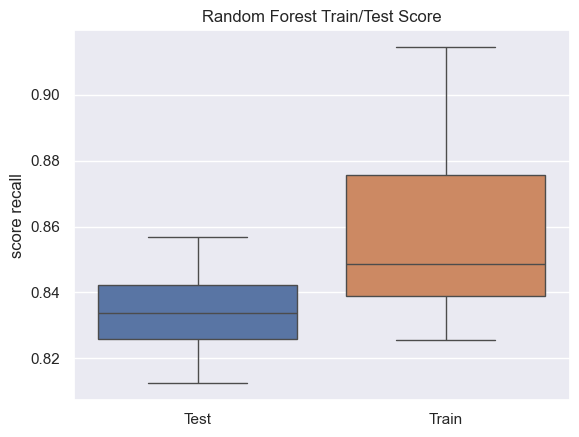

In [34]:
rf_list = pd.DataFrame(zip(mean_test_score_rf,model_rf.cv_results_['mean_train_score']),columns=['Test','Train'])
sns.boxplot(rf_list)
plt.title('Random Forest Train/Test Score')
plt.ylabel('score recall');

# 4 Best Model

In [39]:
#Load best model from mlflow
best_model = mlflow.sklearn.load_model(f"models:/SVM/12")
print(best_model.get_params)

#training best model
best_model_train = best_model.fit(X_train_bal,y_train_bal)

#testing best model
y_pred_best_model = best_model_train.predict(X_test)

#Checking Overfitting
y_pred_best_model_train = best_model_train.predict(X_train_bal)

<bound method BaseEstimator.get_params of SVC(C=0.001, degree=1, kernel='poly', probability=True)>


## 4.1 Evaluation

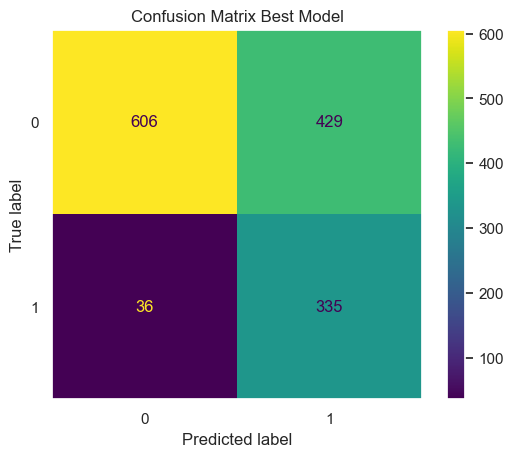

In [40]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix Best Model')
plt.grid()

In [41]:
#Evaluation
print('recall:',recall_score(y_test,y_pred_best_model))
print('')
print('accuracy_score:' ,accuracy_score(y_test,y_pred_best_model))
print('precision_score:', precision_score(y_test,y_pred_best_model))
print('f1_score:', f1_score(y_test,y_pred_best_model))
print('roc_auc_score:', roc_auc_score(y_test,y_pred_best_model))

recall: 0.9029649595687331

accuracy_score: 0.6692745376955903
precision_score: 0.43848167539267013
f1_score: 0.5903083700440529
roc_auc_score: 0.7442361029727724


In [42]:
print('recall train:',recall_score(y_train_bal,y_pred_best_model_train))
print('accuracy train:',accuracy_score(y_train_bal,y_pred_best_model_train))

recall train: 0.902391882097125
accuracy train: 0.7411210437303697
